<h1>ATSC 409</h1>
<h2>Miniproject 2<h2>
<h3>Timothy Chui</h3>
<h3>37695129</h3>

In [1]:
# make new yaml file for miniproject

import yaml
timevars={'timevars':{'dt':0.1,'tstart':0.0,'tend':100.0}}
# chid = constant death of daisies
# chir = constant death of rabbits
# chif = constant death of foxes

# phi = proportionality constant for daisy death due to rabbits
# theta = proportionality constant for rabbit death due to foxes

# betar = constant growth rate of rabbits
# betaf = constant growth rate of foxes

# initialize yaml file for rabbits only, no foxes (i.e. set all fox-based parameters to 0)
uservars={'uservars':{'albedo_white':0.75,'chid':0.3,'chir':0.3,'chif':0.0,'phi':1,'theta':0.0,
                      'betar':0.5,'betaf':0.0,'S0':3668.0,'L':1.1,'albedo_black':0.25,
                      'R':0.12,'sigma':5.67e-08,'albedo_ground':0.5}} 
initvars={'initvars':{'whiteconc':0.2,'blackconc':0.7, 'rabbitconc':0.1, 'foxconc':0.0}} # add rabbit and fox conc.
adaptvars={'adaptvars':{'dtpassmin':0.1,'dtfailmax':0.5,'dtfailmin':0.1,'s':0.9,'rtol':1.0e-05,
           'atol':1.0e-05,'maxsteps':2000.0,'maxfail':60.0,'dtpassmax':5.0}}

with open('miniproject_2.yaml','w') as f:
    f.write(yaml.dump(timevars,default_flow_style=False))
    f.write(yaml.dump(uservars,default_flow_style=False))
    f.write(yaml.dump(initvars,default_flow_style=False))
    f.write(yaml.dump(adaptvars,default_flow_style=False))   

In [2]:
# function to load/restart yaml file, and initialize the dictionaries for easy edits
def reset_params():
    with open("miniproject_2.yaml", "r") as yaml_file:
        yaml_all = yaml.load(yaml_file)
        uservars_init = yaml_all["uservars"]
        initvars_init = yaml_all["initvars"]
    return uservars_init, initvars_init

In [3]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

class IntegProject(Integrator):
    """Child of Integrator class for dealing with rabbit and fox populations as well
       Adapted from Integ54; includes mammal population and its effects on the daisy population
    """

    def set_yinit(self, uservars_init, initvars_init):
        # set new initial conditions
        for init_key in initvars_init:
            self.config["initvars"][init_key] = initvars_init[init_key]
        
        # set new parameters
        for user_key in uservars_init:
            self.config["uservars"][user_key] = uservars_init[user_key]
        
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc, self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name, uservars_init, initvars_init):
        super().__init__(coeff_file_name)
        self.set_yinit(uservars_init, initvars_init)

        
    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=rabbits/area
           y[3]=foxes/area
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        beta_b, beta_w = self.find_growth(temp_b, temp_w) # overwrote to use new find_growth method
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 4 element vector to hold the derivative
        f = np.empty_like(y)
        chi_daisies = user.phi*y[2] + user.chid # death rate of daisies
        chi_rabbits = user.theta*y[3] + user.chir # death rate of rabbits
        f[0] = y[0] * (beta_w * bare - chi_daisies) # white daisies
        f[1] = y[1] * (beta_b * bare - chi_daisies) # black daisies
        f[2] = y[2] * (user.betar*(1-bare) - chi_rabbits) # rabbits
        f[3] = y[3] * (user.betaf*y[2] - user.chif) # foxes
        return f
    
    # make new method for calculating growth rates
    def find_growth(self, temp_b, temp_w):
        """Calculate growth rates based on local temperatures"""
        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        return beta_b, beta_w
       
    def timeloop5Err(self):
        """return errors as well as values
        """
        t = self.timevars
        a = self.adaptvars
        i = self.initvars
        nvars = self.nvars
        oldTime = t.tstart
        olddt = t.dt
        yold = self.yinit
        yerror = np.zeros_like(yold)
        num = 0
        badsteps = 0
        goodsteps = 0
        timeVals = []
        yvals = []
        errorList = []
        while(oldTime < t.tend):
            timeVals.append(oldTime)
            yvals.append(yold)
            errorList.append(yerror)
            if(num > a.maxsteps):
                raise Exception('num > maxsteps')
            # start out with goodstep false and
            # try different sizes for the next step
            # until one meets the error conditions
            # then move onto next step by setting
            # goodstep to true
            goodStep = False
            failSteps = 0
            while(not goodStep):
                # to exit this loop, need to
                # get the estimated error smaller than
                # the desired error set by the relative
                # tolerance
                if(failSteps > a.maxfail):
                    raise Exception('failSteps > a.maxfail')
                #
                # try a timestep, we may need to reverse this
                #
                ynew, yerror, timeStep = self.rkckODE5(yold, oldTime, olddt)
                # print("try a step: : ", ynew)
                #
                # lab 5 section 4.2.3
                # find the desired tolerance by multiplying the relative
                # tolerance (RTOL) times the value of y
                # compare this to the error estimate returnd from rkckODE5
                # atol takes care of the possibility that y~0 at some point
                #
                errtest = 0.
                for i in range(nvars):
                    errtest = errtest + \
                        (yerror[i] / (a.atol + a.rtol * np.abs(ynew[i])))**2.0
                errtest = np.sqrt(errtest / nvars)
                #
                # lab5 equation 4.13, S
                #
                dtchange = a.s * (1.0 / errtest)**0.2
                # print("dtchange, errtest, timeStep: ",
                #       dtchange, errtest, timeStep, ynew, yerror)
                if (errtest > 1.0):
                    # estimated error is too big so
                    # reduce the timestep and retry
                    # dtFailMax ~ 0.5, which guarantees that
                    # the new timestep is reduced by at least a
                    # factor of 2
                    # dtFailMin~0.1, which means that we don't trust
                    # the estimate to reduce the timestep by more
                    # than a factor of 10 in one loop
                    if(dtchange > a.dtfailmax):
                        olddt = a.dtfailmax * olddt
                    elif (dtchange < a.dtfailmin):
                        olddt = a.dtfailmin * olddt
                    else:
                        olddt = dtchange * olddt
                    if (timeStep + olddt == timeStep):
                        raise Exception('step smaller than machine precision')
                    failSteps = failSteps + 1
                    #
                    # undo the timestep since the error wasn't small enough
                    #
                    ynew = yold
                    timeStep = oldTime
                    # go back to top and see if this olddt produices
                    # a better yerrror
                else:
                    # errtest < 1, so we're happy
                    # try to enlarge the timestep by a factor of dtChange > 1
                    # but keep it smaller than dtpassmax
                    # try enlarging the timestep bigger for next time
                    # dtpassmin ~ 0.1 and dtpassmax ~ 5
                    if (abs((1.0 - dtchange)) > a.dtpassmin):
                        if(dtchange > a.dtpassmax):
                            dtnew = a.dtpassmax * olddt
                        else:
                            dtnew = dtchange * olddt
                    else:
                        # don't bother changing the step size if
                        # the change is less than dtpassmin
                        dtnew = olddt
                    goodStep = True
                    #
                    # overwrite the old timestep with the new one
                    #
                    oldTime = timeStep
                    yold = ynew
                    # go back up to top while(timeStep < t.tend)
                    goodsteps = goodsteps + 1
                #
                # this is number of times we decreased the step size without
                #  advancing
                #
                badsteps = badsteps + failSteps
            # special case if we're within one ortwo timesteps of the end
            # otherwise, set dt to the new timestep size
            if(timeStep + dtnew > t.tend):
                olddt = t.tend - timeStep
            elif(timeStep + 2.0 * dtnew > t.tend):
                olddt = (t.tend - timeStep) / 2.0
            else:
                olddt = dtnew
                
                
        timeVals = np.array(timeVals).squeeze()
        yvals = np.array(yvals).squeeze()
        errorVals = np.array(errorList).squeeze()
        self.timevals = timeVals
        self.yvals = yvals
        self.errorVals = errorVals
        return (timeVals, yvals, errorVals)


black = 0.1367151956268895

white = 0.4668500040867656

rabbits = 0.06792751404588866

foxes = 0.0



(0, 1)

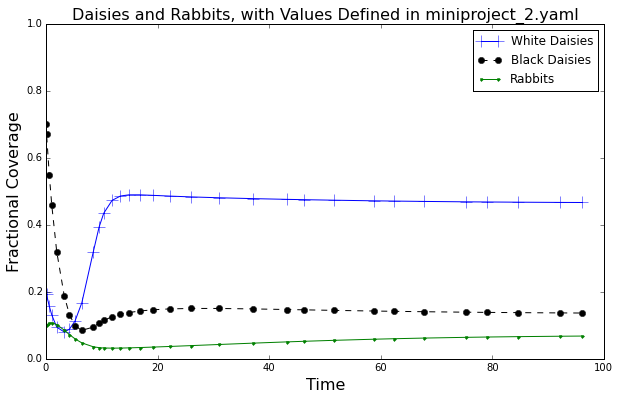

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# set dictionaries to play around with initial conditions and parameters
uservars_init,initvars_init = reset_params()

# call class and integrate forward in time
theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbits','foxes'])

# plot fractional coverage with time, for case with no foxes
thefig,theAx=plt.subplots(1,1, figsize=(10,6))

points,=theAx.plot(timeVals,yvals['white'],'-b+',label='White Daisies')
points.set_markersize(12)
theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='Black Daisies')
theLine2,=theAx.plot(timeVals,yvals['rabbits'],'-g.',label='Rabbits')
theAx.set_title('Daisies and Rabbits, with Values Defined in miniproject_2.yaml', fontsize=16)
theAx.set_xlabel('Time', fontsize=16)
theAx.set_ylabel('Fractional Coverage', fontsize=16)
out=theAx.legend(loc='best')

print("black = {}\n".format(yvals['black'].iloc[-1]))
print("white = {}\n".format(yvals['white'].iloc[-1]))
print("rabbits = {}\n".format(yvals['rabbits'].iloc[-1]))
print("foxes = {}\n".format(yvals['foxes'].iloc[-1]))
theAx.set_ylim([0,1])

In [5]:
# now play around with initial conditions

def plot_final(is_init, should_reset, change_key, change_array, uservars_init, initvars_init):
    """Facilitates plotting of final values
    
       is_init = True if taken from initvars_init, False if from uservars_init
       should_reset = True if using default values other than change_array
       change_key = dictionary key 
       change_array = array of initial values or parameters
       uservars_init = dictionary of uservars
       initvars_init = dictionary of initvars
    """
    # use default values?
    if should_reset:
        uservars_init,initvars_init = reset_params()
        
    # make arrays for final values
    white_end = []
    black_end = []
    rabbit_end = []

    for each_change in change_array:
        initvars_init[change_key] = each_change
        theSolver=IntegProject('miniproject_2.yaml', uservars_init, initvars_init)
        timeVals,yVals,errorList=theSolver.timeloop5Err()

        white_end.append(yVals[-1,0])
        black_end.append(yVals[-1,1])
        rabbit_end.append(yVals[-1,2])
        
    thefig,theAx=plt.subplots(1,1,figsize=(8,4))
    points,=theAx.plot(change_array,white_end,'-b+',label='White Daisies')
    points.set_markersize(12)
    theLine1,=theAx.plot(change_array,black_end,'--ko',label='Black Daisies')
    theLine2,=theAx.plot(change_array,rabbit_end,'-g.',label='Rabbits')
    
    out=theAx.legend(loc='best')
    
    return thefig,theAx
    


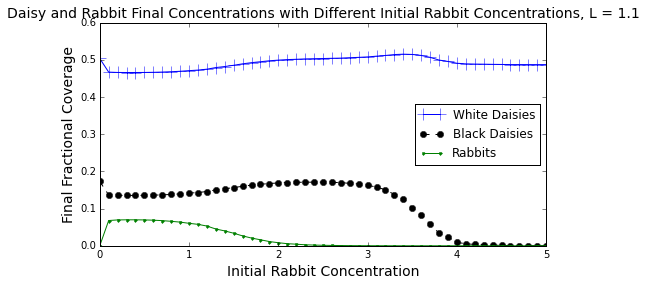

In [6]:
# different rabbit initial conditions
rabbit_inits = np.arange(0.0,5.05,0.1)
change_key = "rabbitconc"
is_init = True
should_reset = True
thefig1,theAx1 = plot_final(is_init, should_reset, change_key, rabbit_inits, uservars_init, initvars_init)

theAx1.set_title('Daisy and Rabbit Final Concentrations with Different Initial Rabbit Concentrations, L = {}'.format(uservars_init["L"]),
                 fontsize=14)
theAx1.set_xlabel('Initial Rabbit Concentration',fontsize=14)
theAx1.set_ylabel('Final Fractional Coverage',fontsize=14)

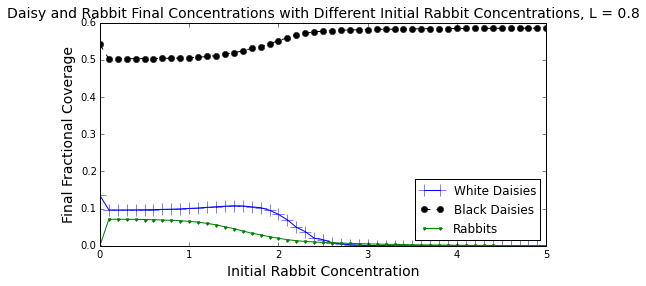

In [7]:
# but what about with a lower L?
rabbit_inits = np.arange(0.0,5.1,0.1)
change_key = "rabbitconc"
is_init = True
should_reset = False 

uservars_init["L"] = 0.8
thefig2,theAx2 = plot_final(is_init, should_reset, change_key, rabbit_inits, uservars_init, initvars_init)

theAx2.set_title('Daisy and Rabbit Final Concentrations with Different Initial Rabbit Concentrations, L = {}'.format(uservars_init["L"]),
                 fontsize=14)
theAx2.set_xlabel('Initial Rabbit Concentration',fontsize=14)
theAx2.set_ylabel('Final Fractional Coverage',fontsize=14)